In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib 
import matplotlib.pyplot as plt 
import skimage
from skimage import io
from skimage import filters
from nilearn import datasets
import modules
from nilearn import plotting

In [2]:
img = nib.load(r'\Users\nakag\OneDrive\Escritorio\squizo\sub-01\anat\sub-01_T1w.nii.gz')
img2 = nib.load(r"\Users\nakag\OneDrive\Escritorio\squizo\sub-17\anat\sub-17_T1w.nii.gz")

In [3]:
data = img.get_fdata()

In [4]:
print(data.shape)

(176, 256, 256)


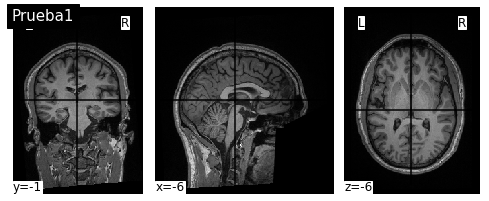

In [5]:
plotting.plot_img(img, title="Prueba1",display_mode='ortho',cmap=plt.cm.gray )
plotting.show()   

In [6]:

a = np.array(skimage.transform.resize(img.dataobj, (50,70)))
#a = np.array(skimage.transform.rescale(img.dataobj,0.3))
a.shape

(50, 70, 256)

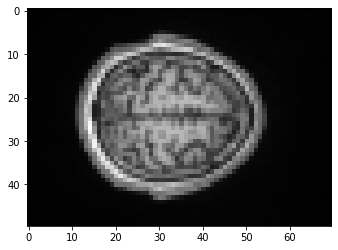

In [7]:
img_gray= a[:,:,180]
#normalizo la imagen
img_o=img_gray
img_o=img_o/np.max(img_o)
plt.imshow(img_gray, cmap=plt.cm.gray)

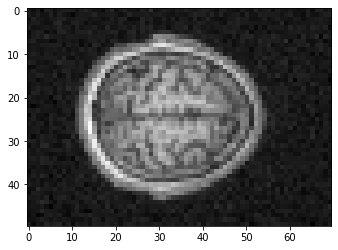

In [8]:
#Aplicar ruido gaussiano
img_gauss=modules.add_gnoise('gauss',img_o,0.03)
plt.imshow(img_gauss, cmap=plt.cm.gray)

C:\Users\nakag\OneDrive\Escritorio\IMagen\FormatoEntrega\modules.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ruido_output[pos]=1
C:\Users\nakag\OneDrive\Escritorio\IMagen\FormatoEntrega\modules.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ruido_output[pos]=0


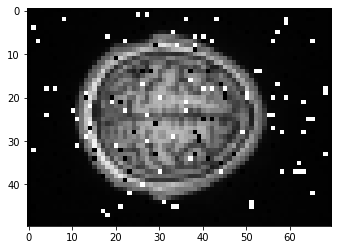

In [9]:
#Aplicar ruido impulsivo
img_salpimienta=modules.salpimienta('s&p',img_o,0.05)
plt.imshow(img_salpimienta, cmap=plt.cm.gray)

In [15]:
denoise_img = modules.aniso_filter(img_gauss, 20, 10)

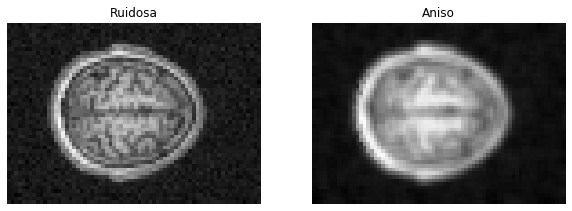

In [17]:
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img_gauss,cmap=plt.cm.gray)
plt.title('Ruidosa'), plt.axis('off')
plt.subplot(122)
plt.title('Aniso'), plt.axis('off')
plt.imshow(denoise_img, cmap=plt.cm.gray)